# Time Series Forecastig for Airline Passenger Traffic Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

results = pd.DataFrame({'Method':['0'], 'RMSE':[0], 'MAPE':[0]})

In [2]:
data = pd.read_csv('airline-passengers.csv')
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')

## Time Sries Analysis

In [3]:
data.head()


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
data.tail()

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [5]:
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### Visualize the time series data

<Axes: xlabel='Month'>

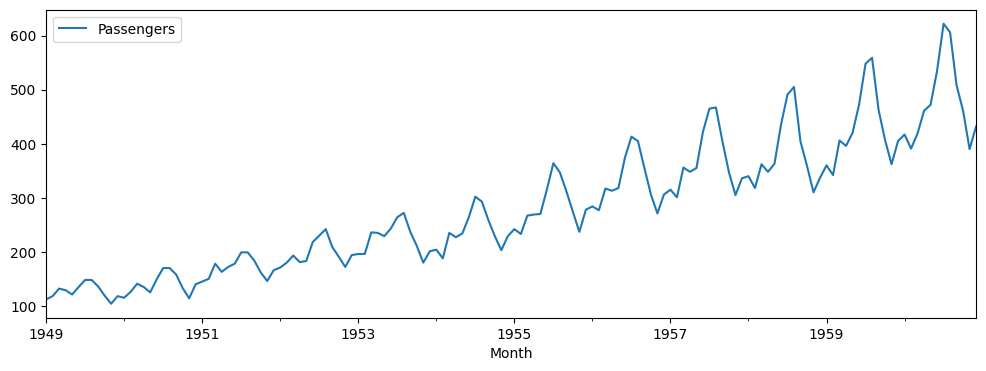

In [6]:
data.plot(figsize=(12,4))

### Time Series Decomposition

#### Additive Seasonal Decomposition

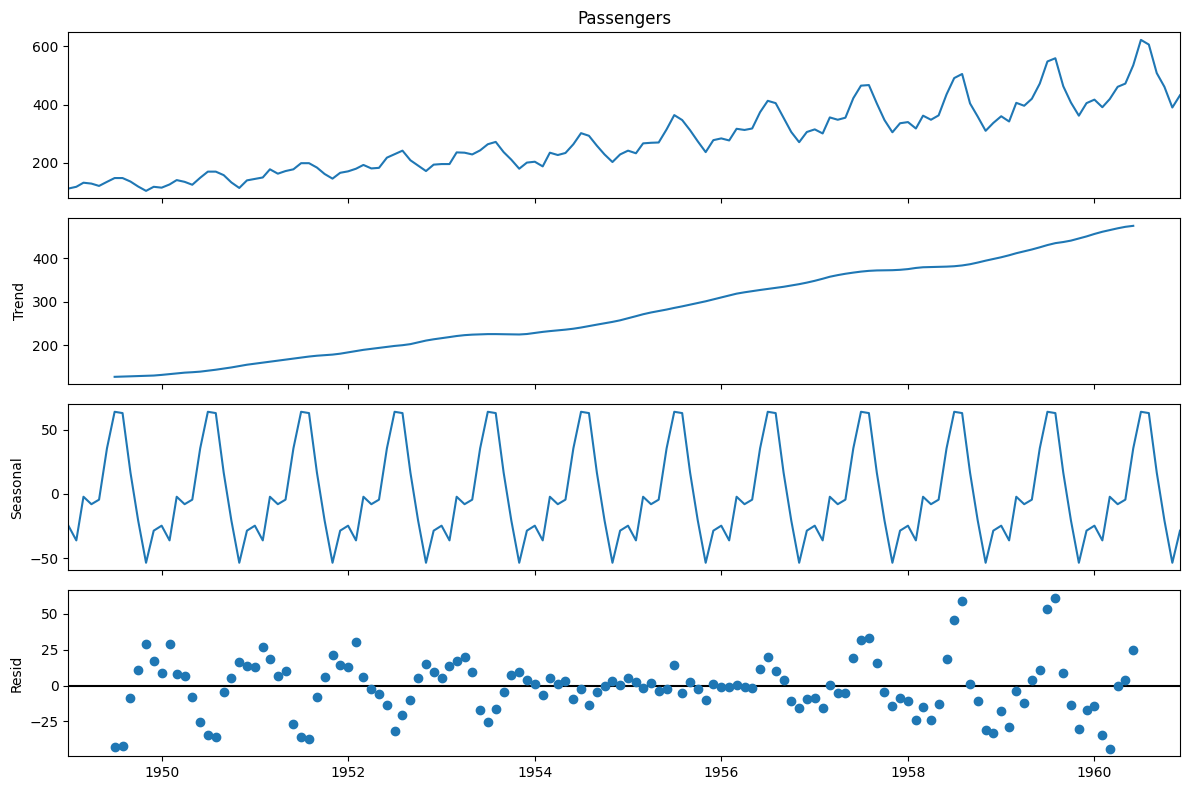

In [7]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='additive')
fig = decomposition.plot()
plt.show()

#### Multiplicative Seasonal Decomposition

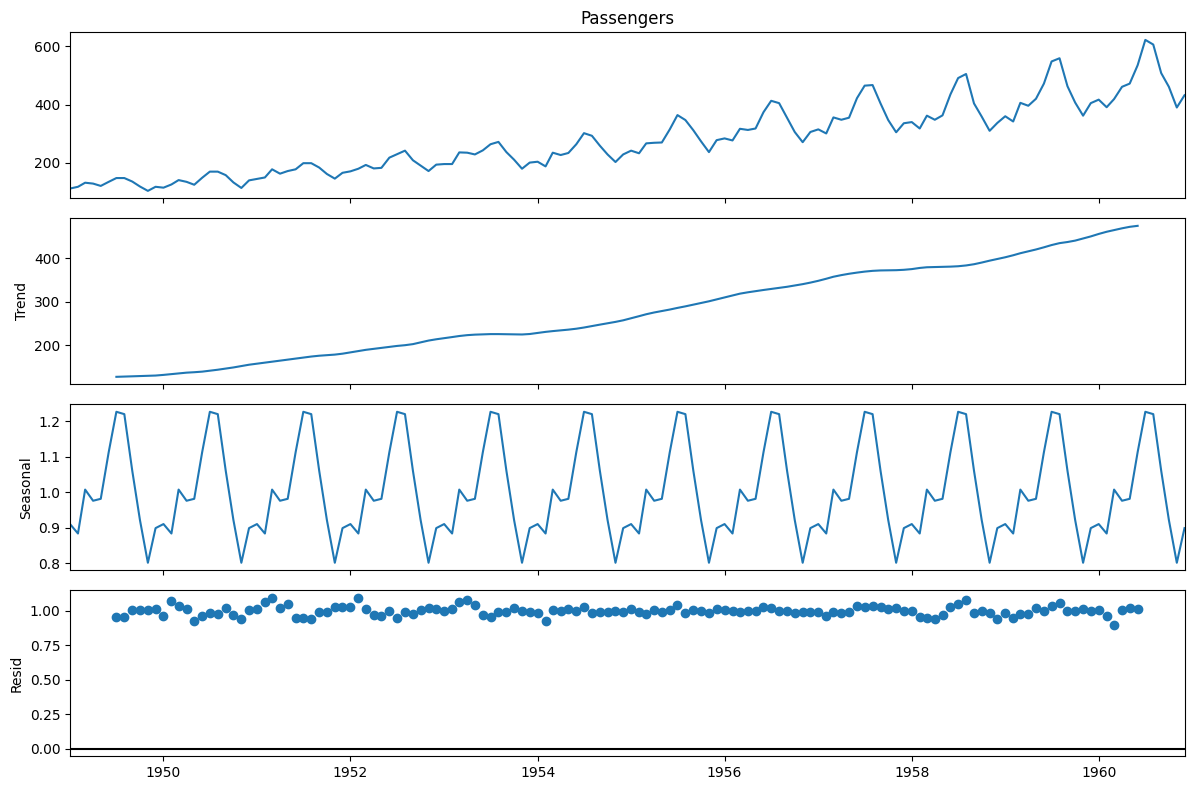

In [8]:
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Checking Stationarity

### Visually Checking Stationarity

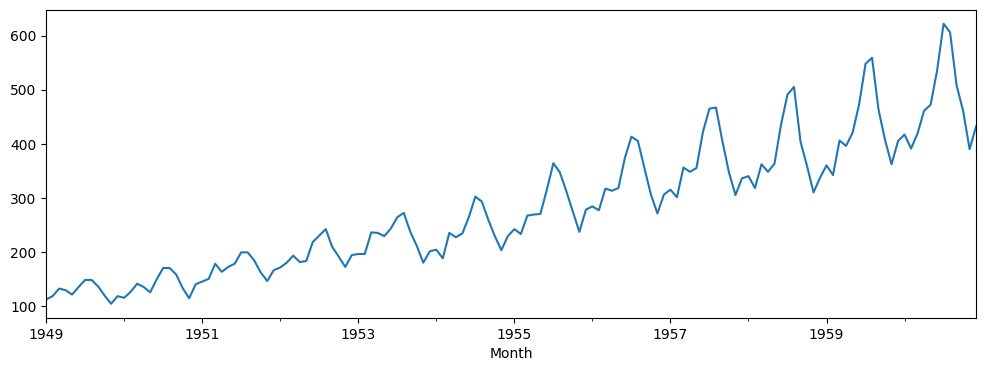

In [9]:
data['Passengers'].plot(figsize=(12,4))
plt.show()

***Analysis***
1. We can see that there is an increasing Trend. So, Trend is not constant.
2. Variance is also not constant.

### Augmented Dickey-Fuller (ADF) Test

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
adf_test = adfuller(data['Passengers'])
print('ADF stats: %f' % adf_test[0])
print('p-value: %f' %adf_test[1])
print('Critical value @ 0.05: %.2f' % adf_test[4]['5%'])

ADF stats: 0.815369
p-value: 0.991880
Critical value @ 0.05: -2.88


***Analysis***

p-value (0.99) > critical value(0.05) .

Failed to reject null hypothesis (The series is not stationary)

Hence, the time series is Non-Stationary.

## Converting Non-Stationary to Stationary Time Series

### Box Cox Transformation

Box-Cox transformation makes the variance constant in a series.

In [12]:
from scipy.stats import boxcox

# Creating a new dataset with the boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), data.index)
data_boxcox.head()

,0
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


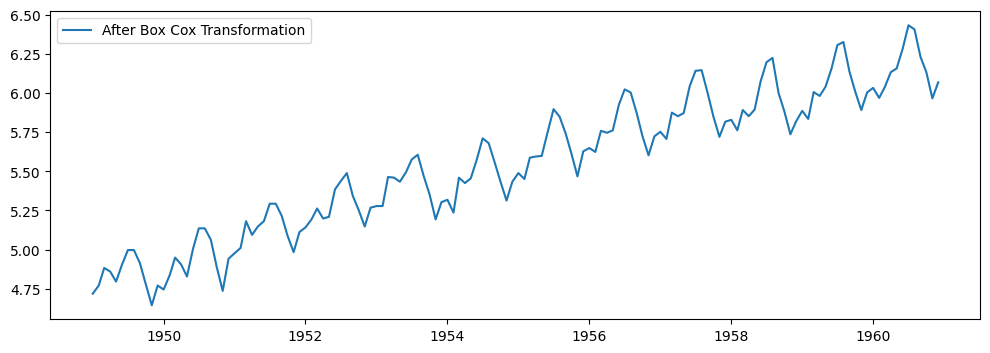

In [13]:
# Plotting the Time series after transformation
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox Transformation')
plt.legend(loc='best')
plt.show()

### Differencing

Differencing is performed by subtracting the previous observation from the current observation.

Differencing removes trend and seasonality in a Time series. When an entire cycle is used for differencing the other cycle, then the seasonality is removed.

### Differenceing wiht shift 1

In [14]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index=data.index)

# As the first record becomes null. Hence removing the frist observation.
data_boxcox_diff.dropna(inplace=True)

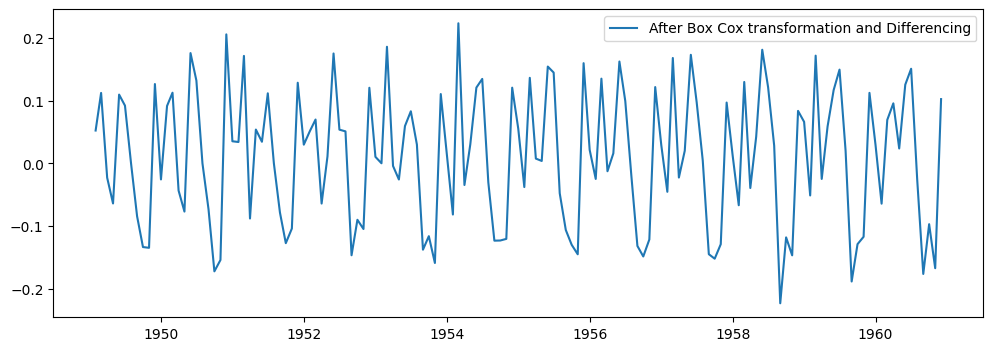

In [15]:
# Plotting the Time series after Box Cox transformation and Differencing
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox transformation and Differencing')
plt.legend(loc='best')
plt.show()

We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation.

It is a horizontal trend.

The mean became constant. The mean is zero.

Also, the variance is almost constant.

Lets test the Stationarity again.

#### ADF Test

In [16]:
adf_test = adfuller(data_boxcox_diff)
print('ADF stats: %f' % adf_test[0])
print('p-value: %f' %adf_test[1])
print('Critical value @ 0.05: %.2f' % adf_test[4]['5%'])

ADF stats: -2.717131
p-value: 0.071121
Critical value @ 0.05: -2.88


p-value(0.07) > critical value(0.05)

Failed to reject null hypothesis (The series is not stationary)

### Differenceing wiht shift 2

In [17]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(2), index=data.index)

# As the first record becomes null. Hence removing the frist observation.
data_boxcox_diff.dropna(inplace=True)

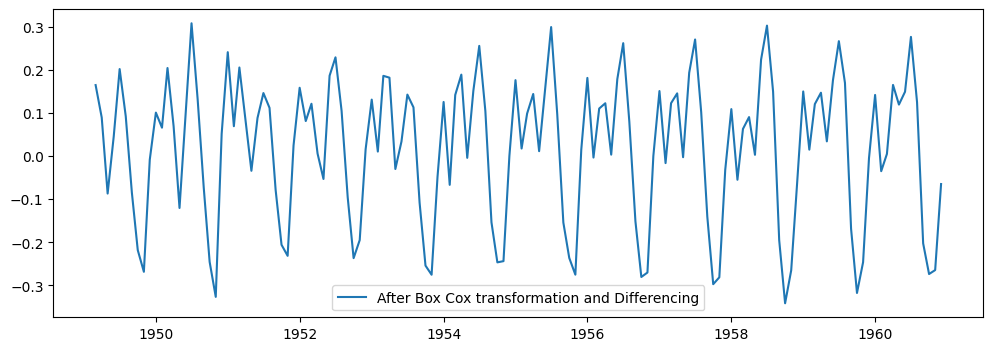

In [18]:
# Plotting the Time series after Box Cox transformation and Differencing
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox transformation and Differencing')
plt.legend(loc='best')
plt.show()

#### ADF Test

In [19]:
adf_test = adfuller(data_boxcox_diff)
print('ADF stats: %f' % adf_test[0])
print('p-value: %f' %adf_test[1])
print('Critical value @ 0.05: %.2f' % adf_test[4]['5%'])

ADF stats: -3.167907
p-value: 0.021919
Critical value @ 0.05: -2.88


p-value(0.02) < critical value(0.05)

ADF stats < Critical value .

Hence, Reject the null hypothesis.

The series is ***Stationary***.

***Hence the difference value, d = 2***

## Autocorrelation

### Autocorrelation function (ACF)

Autocorrelation function captures both direct and indirect relationship with its lagged values.

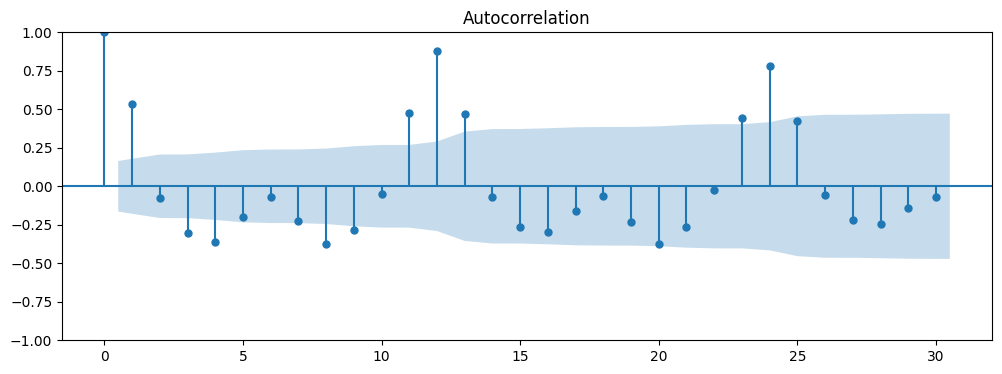

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

The shaded portion is the less significant.

With lag 0, the series is just correlated with itself. Hence, correlation=1 at lag=0.

ACF captures both direct and indirect correlation with the lag time.

***Hence the AR lag, p=1***

### Partial Autocorrelation Function (PACF)

Captures only direct correlation

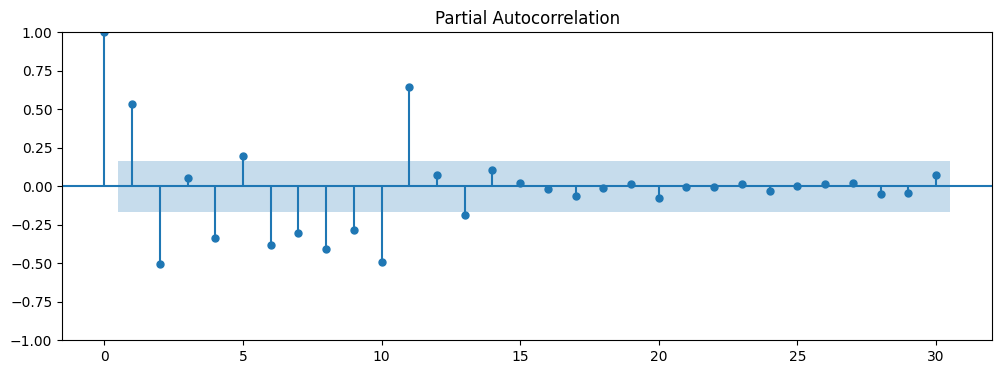

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

Little change in the correlation plot. Because PACF only captures the direct correlation with the time lag. It bypasses the tile lags in between.

***Hence the MA lag, q=2***

## Splitting data into Train and Test set

We are going to forecast for last two years - ***1959 and 1960***.

Train Set : 1949 to 1958 - 120 months

Test Set  : 1959 to 1960 - 24 months

In [22]:
train_len = 120
# 1949 to 1958 data
train = data[0:train_len]
train_boxcox = data_boxcox[0:train_len]
# 1959 and 1960 data
test = data[train_len:]
test_boxcox = data_boxcox[train_len:]

In [23]:
test.head()

,Passengers
Month,
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396
1959-05-01,420


In [24]:
test_boxcox.head()

,0
Month,
1959-01-01,5.886104
1959-02-01,5.834811
1959-03-01,6.006353
1959-04-01,5.981414
1959-05-01,6.040255


## Auto Regressive Integrated Moving Average (ARIMA)

Automatically performs the Differencing if the series has trend.

Hence, no need to manually perform the differencing.

### Modeling

In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
# Passing only the transformed boxcox data. Because ARIMA automatically performing the differencing.
# p = 1
# d = 1   , We are doing two order differencing.
# q = 2   , MA lag is 2
model = ARIMA(train_boxcox, order=(1,2,2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
model_fit = model.fit()
model_fit.params

,0
ar.L1,-0.574537
ma.L1,-0.165243
ma.L2,-0.834724
sigma2,0.010215


### Evaluation

In [28]:
y_hat_arima = data_boxcox.copy()

In [30]:
y_hat_arima['arima_forecast_boxcox'] = model_fit.predict(data_boxcox.index.min(), data_boxcox.index.max())

In [31]:
# Reverse the transformation
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

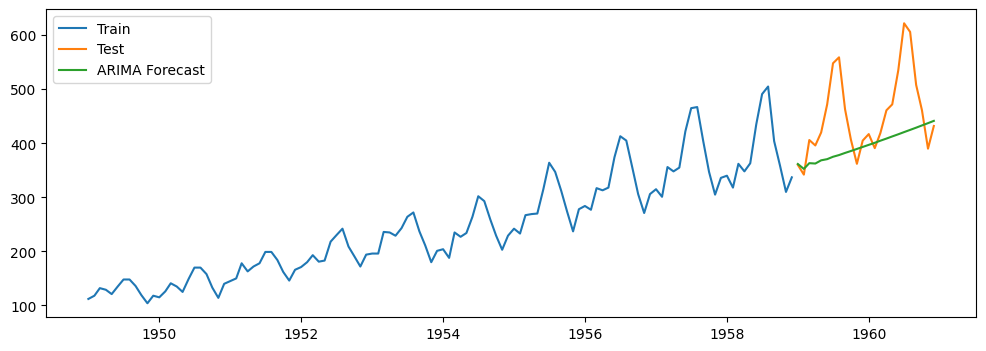

In [32]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA Forecast')
plt.legend(loc='best')
plt.show()

### Loss Calculation

In [33]:
from sklearn.metrics import mean_squared_error

#### RMSE (Root mean squared error)

In [34]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)

#### MAPE (Mean absolute percentage error)

In [35]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100),2)

In [36]:
results.loc[len(results)] = {'Method':'ARIMA method', 'RMSE':rmse, 'MAPE':mape}
results

,Method,RMSE,MAPE
0,0,0.00,0.00
1,ARIMA method,89.02,12.85


## Seasonal Auto Regressive Integrated Moving Average (SARIMA)

ARIMA with Seasonal component added.

Automatically performs the Differencing if the series has trend.

Hence, no need to manually perform the differencing.

### Modeling

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
# seasonal_order P=1, Q=2, D=2 and m=12
# m=12 . Because the seasonality is monthly.
model = SARIMAX(train_boxcox, order=(0,0,0), seasonal_order=(1,2,2,12))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [39]:
model_fit = model.fit()
model_fit.params

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


,0
ar.S.L12,0.216748
ma.S.L12,-1.656873
ma.S.L24,0.956193
sigma2,0.003477


### Evaluation

In [40]:
y_hat_sarima = data_boxcox.copy()

In [41]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox.index.min(), data_boxcox.index.max())

In [42]:
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

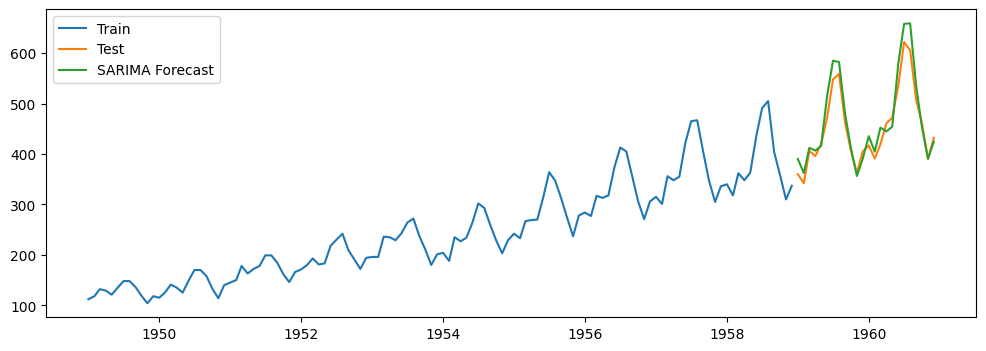

In [43]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

### Loss Calculation

In [44]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)

In [45]:
mape = round(np.mean(np.abs((test['Passengers'] - y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100),2)

In [46]:
results.loc[len(results)] = {'Method':'SARIMA method', 'RMSE':rmse, 'MAPE':mape}

## Modeling using Prophet (Meta AI)

Meta's Prophet having following advantages

* ***Accurate and Fast:*** It is accurate and can generate results a lot faster compared to other time series libraries.
* ***Reliable:*** It can accommodate strong seasonal effects in the data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
* ***Domain Knowledge integration:*** Forecasting can be made better by adding domain knowledge expertise like holidays and patterns.

### Install Dependencies

In [48]:
!pip install prophet

### Modeling

***Prophet*** takes a dataframe as input with only 2 columns - ***ds and y***. The ds (datestamp) column should be in a specific format, ideally *YYYY-MM-DD* for a date or *YYYY-MM-DD HH:MM:SS* for a timestamp to be parsed by Prophet. The y column must be numeric, and represents the variable we wish to forecast. Therefore we must rename the columns before proceeding further

In [52]:
from prophet import Prophet

# Change column names to ds and y
prophet_df = train.reset_index()[['Month', 'Passengers']].rename(columns={'Month': 'ds', 'Passengers': 'y'})
prophet_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


***Fit the model to the data***

In [55]:
model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpejgs4zon/29j766t9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpejgs4zon/nr8066ho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11526', 'data', 'file=/tmp/tmpejgs4zon/29j766t9.json', 'init=/tmp/tmpejgs4zon/nr8066ho.json', 'output', 'file=/tmp/tmpejgs4zon/prophet_model96yrzd3j/prophet_model-20241229093708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Evaluation

In [76]:
future_dates = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(future_dates)
forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
139,1960-08-01,466.199783,497.752299,545.272990,464.871955,467.532725,55.656752,55.656752,55.656752,55.656752,55.656752,55.656752,0.0,0.0,0.0,521.856535
140,1960-09-01,469.184392,458.429924,506.819223,467.771999,470.601514,13.022146,13.022146,13.022146,13.022146,13.022146,13.022146,0.0,0.0,0.0,482.206538
141,1960-10-01,472.072724,425.796770,473.523951,470.541777,473.589932,-22.187697,-22.187697,-22.187697,-22.187697,-22.187697,-22.187697,0.0,0.0,0.0,449.885027
142,1960-11-01,475.057333,398.470039,443.706852,473.414928,476.690931,-53.342411,-53.342411,-53.342411,-53.342411,-53.342411,-53.342411,0.0,0.0,0.0,421.714922
143,1960-12-01,477.945664,424.597474,471.403245,476.149407,479.667027,-29.973937,-29.973937,-29.973937,-29.973937,-29.973937,-29.973937,0.0,0.0,0.0,447.971727


In [67]:
forecast_ = forecast.set_index('ds')

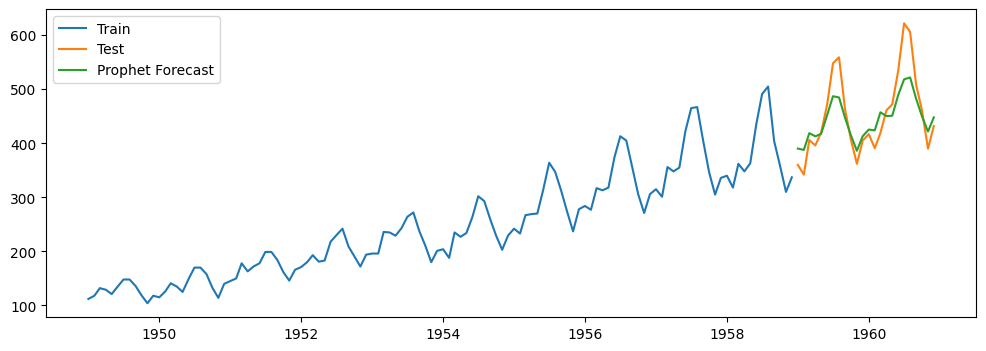

In [70]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(forecast_['yhat'][test.index.min():], label='Prophet Forecast')
plt.legend(loc='best')
plt.show()

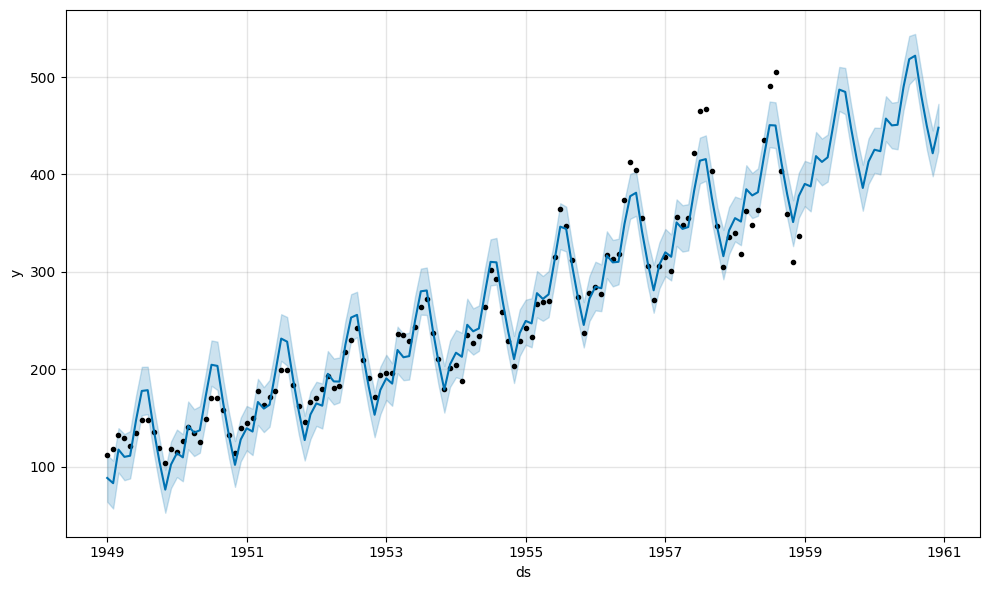

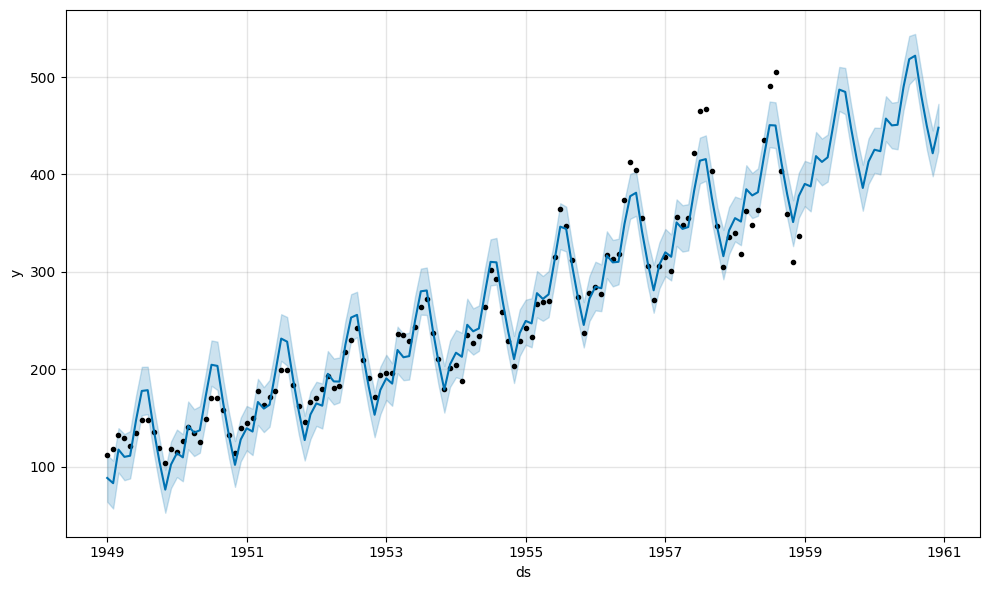

In [71]:
model.plot(forecast)

### Loss Calculation

#### RMSE

In [72]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], forecast_['yhat'][test.index.min():])).round(2)

#### MAPE

In [73]:
mape = round(np.mean(np.abs((test['Passengers'] - forecast_['yhat'][test.index.min():])/test['Passengers'])*100),2)

In [74]:
results.loc[len(results)] = {'Method':'Prophet method', 'RMSE':rmse, 'MAPE':mape}
results

,Method,RMSE,MAPE
0,0,0.00,0.00
1,ARIMA method,89.02,12.85
2,SARIMA method,25.04,4.36
3,Prophet method,40.39,6.54


## Conclusion

In [75]:
results

,Method,RMSE,MAPE
0,0,0.00,0.00
1,ARIMA method,89.02,12.85
2,SARIMA method,25.04,4.36
3,Prophet method,40.39,6.54


SARIMA is the best model we got with low RMSE(25.04) and low MAPE(4.36) value.